## 1. Import libraries

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [2]:
import cv2 
import mediapipe as mp
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
EPOCHS = 250
RANDOM_SEED = np.random.seed(10)
BATCH_SIZE = 32

## 2. Initialize MediaPipe modules

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model 
mp_drawing = mp.solutions.drawing_utils # Drawing utilities 
mp_face_mesh = mp.solutions.face_mesh

In [5]:
#     conda create -n my_gpu_env python=3.x
#     conda activate my_gpu_env

# conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
import torch
torch.cuda.is_available()

True

## 3. Define Helper

In [6]:
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.setflags(write=False)         # Image is no longer writable
    results = model.process(image)      # Make prediction
    image.setflags(write=True)          # Image is now writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


## 4. Drawing Function

In [7]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

## 5. Main Video Capturing Logic 
(show-no need for training)

In [ ]:
#Main function 
cap = cv2.VideoCapture(0) 
# Set mediapipe model  
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: 
    while cap.isOpened(): 
  
        # Read feed 
        ret, frame = cap.read() 
  
        # Make detections 
        image, results = mediapipe_detection(frame, holistic) 
        print(results) 
          
        # Draw landmarks 
        draw_styled_landmarks(image, results) 
  
        # Show to screen 
        cv2.imshow('Holistic Model Output', image) 
  
        # Break gracefully 
        if cv2.waitKey(10) & 0xFF == ord('q'): 
            break
    cap.release() 
    cv2.destroyAllWindows()

## 6. Extract Keypoint Values 
(x,y,z values from detected body + store in numpy arr or "0")

In [9]:
#same logic as above but in function, so can be used
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # flatten arr of points x,y,z visibility values - single vector

## 7. Setup Folders for Collection

In [ ]:
DATA_PATH = os.path.join('MP_Data_Emotions') 
emotions = np.array([
    'happy',
    'sad',
    'angry',
    'surprise',
    'fear',
    'disgust',
    'neutral'
])
samples_per_emotion = 50

no need to rerun

In [ ]:
for emotion in emotions: 
    os.makedirs(os.path.join(DATA_PATH, emotion), exist_ok = True)

## 8. Collect Keypoint Values for Training and Testing
no need to re-run (have collected)

In [ ]:
cap = cv2.VideoCapture(0)
stop = False
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for emotion in emotions:
        sample_count = 0
        print('STARTING COLLECTION for {}. Please make the expression for the next 5 seconds.'.format(emotion))
        cv2.waitKey(5000)

        while sample_count < samples_per_emotion:
            ret, frame = cap.read()
            if not ret:
                break

            image, results = mediapipe_detection(frame, holistic)
            
            draw_styled_landmarks(image, results)

            cv2.putText(
                        image, f'Collecting: {emotion}',
                        (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (0,255,0), 2
            )

            cv2.imshow("Emotion Collection", image)

            if results.face_landmarks is None:
                continue
            keypoints = extract_keypoints(results)

            np.save(
                os.path.join(DATA_PATH, emotion, str(sample_count)),
                keypoints
            )

            sample_count += 1
            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                stop = True
                break
                    
    cap.release()
    cv2.destroyAllWindows()

## 9. Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # to one-hot encoding data

In [ ]:
label_map = {label:num for num, label in enumerate(emotions)}
# label dictionary to represent each one of our action

In [18]:
label_map

{np.str_('idontknow'): 0,
 np.str_('areyouok'): 1,
 np.str_('idontunderstand'): 2}

In [ ]:
sequences, labels = [], [] #x, y data
for emotion in emotions:
    for i in range(samples_per_emotion):
        samples = np.load(os.path.join(DATA_PATH, emotion, "{}.npy".format(i)))
        sequences.append(samples)
        labels.append(label_map[emotion])

## With augmentation

In [ ]:
def emotion_augment(kp, prob=0.5):

    if np.random.rand() > prob:
        return kp.copy()

    kp = kp.copy().reshape(-1, 3)

    # --- Rotation ---
    rot_deg = np.random.uniform(-5, 5)
    rad = np.radians(rot_deg)

    rot = np.array([
        [np.cos(rad), -np.sin(rad)],
        [np.sin(rad),  np.cos(rad)]
    ])

    xy = kp[:, :2]
    xy = xy @ rot.T

    # --- Scale ---
    scale = np.random.uniform(0.97, 1.03)
    xy *= scale

    # --- Shift ---
    shift = np.random.uniform(-0.02, 0.02, 2)
    xy += shift

    kp[:, :2] = xy

    # --- Noise ---
    kp += np.random.normal(0, 0.003, kp.shape)

    return kp.reshape(-1)

In [ ]:
sequences, labels = [], []

for emotion in emotions:
    for i in range(samples_per_emotion):

        sample = np.load(os.path.join(DATA_PATH, emotion, f"{i}.npy"))

        # original
        sequences.append(sample)
        labels.append(label_map[emotion])

        # augmented
        aug = emotion_augment(sample)

        sequences.append(aug)
        labels.append(label_map[emotion])

In [26]:
X = np.array(sequences)

In [27]:
X.shape

(300, 50, 1662)

In [28]:
y = to_categorical(labels).astype(int) #to 1 hot encoding

In [29]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [31]:
# X_train.shape

In [32]:
# y_test.shape

## 10. Build and Train LSTM Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard #to monitor model as its training
from sklearn.model_selection import KFold, GroupKFold
from tensorflow.keras.regularizers import l2

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Group each sequence by its sequence number - so all frames from 1 sequence are in same group
groups = np.repeat(np.arange(len(sequences)), 1)
# kfold = GroupKFold(n_splits=5)
kfold = GroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


## Simplify Model

In [36]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# es_callback = EarlyStopping(monitor='val_categorical_accuracy', patience=100, restore_best_weights=True, verbose=1)
rp_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5, verbose=1)

In [ ]:
model = Sequential()

#1. LAYER
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

### 2. LAYER
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.6)) #60% forgetting process (neuron deletion-dropout)

### FULL CONNECTION LAYER
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6)) #60% forgetting process (neuron deletion-dropout)

### OUTPUT LAYER

# Classification process (there are 7 emotion classes)
model.add(Dense(7))
model.add(Activation('softmax'))

# Determination of optimization and performance calculation metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Fold 1


c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - categorical_accuracy: 0.3708 - loss: 1.1132 - val_categorical_accuracy: 0.4500 - val_loss: 1.0620 - learning_rate: 1.0000e-04
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - categorical_accuracy: 0.4417 - loss: 1.0789 - val_categorical_accuracy: 0.2833 - val_loss: 1.1362 - learning_rate: 1.0000e-04
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - categorical_accuracy: 0.3542 - loss: 1.0999 - val_categorical_accuracy: 0.2500 - val_loss: 1.1391 - learning_rate: 1.0000e-04
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - categorical_accuracy: 0.3792 - loss: 1.0859 - val_categorical_accuracy: 0.2667 - val_loss: 1.1246 - learning_rate: 1.0000e-04
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - categorical_accuracy: 0.3958 - loss: 1.0862 - val_categorical_accuracy: 0.2000 - val_loss: 1.1450 - learning_rate: 1.0000e-04
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - categorical_accuracy: 0.3833 - loss: 1.0715 - val_ca

categorical_crossentropy -> multi-class classification

binary_crossentropy -> binary-class classification

MSE -> regressions

In Terminal move to Logs/train: 

tensorboard --logdir=. (to see logs)

In [ ]:
# tensorboard --logdir=. 
# to see logdir

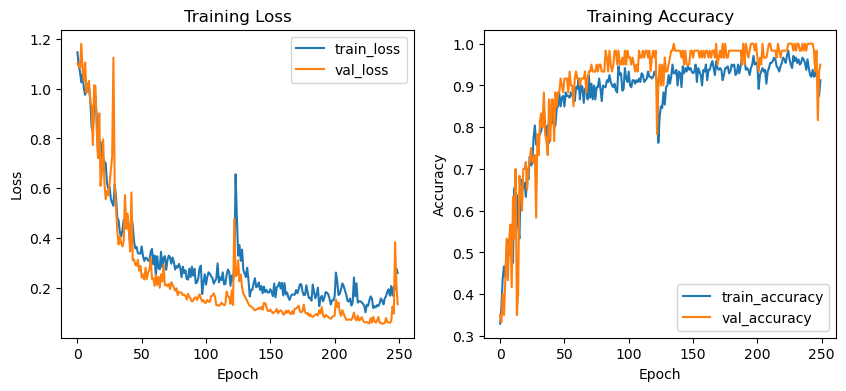

In [38]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [39]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,367,051 (5.21 MB)

 Trainable params: 455,683 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 911,368 (3.48 MB)

## 11. Make Predictions

In [42]:
res = model.predict(X)
# res = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


In [43]:
actions[np.argmax(res[1])] #train data val

np.str_('idontknow')

In [44]:
actions[np.argmax(y[1])] #pred of model
# actions[np.argmax(y_test[1])] #pred of model

np.str_('idontknow')

## 12. Save Model and Load Weights

In [45]:
model.save('fixed_random.h5')

In [46]:
model.load_weights('fixed_random.h5')

# 13. Evaluation using Confusion Matrix and Accuracy


In [47]:
yhat = model.predict(X)
# yhat = model.predict(X_test)

# axis=1 -> want to convert second dim in the arr
# ytrue = np.argmax(y_test, axis=1).tolist()
ytrue = np.argmax(y, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist() # numbers of classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


In [48]:

from sklearn.metrics import accuracy_score
accuracy_score(ytrue, yhat)

0.9133333333333333

## Check class imbalance （label-lvl）

In [49]:
import pandas as pd

# 1-hot encoded to 3 classes back to check
y_idx = np.argmax(y, axis=1)
# count number of samples(sequences) for each class
val_counts = pd.Series(y_idx).value_counts().sort_index()
print("Counts per class:\n", val_counts)
# Divided to get proportion
print("\nProportions:\n", (val_counts / val_counts.sum()).round(3))


Counts per class:
 0    100
1    100
2    100
Name: count, dtype: int64

Proportions:
 0    0.333
1    0.333
2    0.333
Name: count, dtype: float64


## Check class imbalance （zero frames)

In [50]:
root = "MP_Data"
rows = []

# loop over each sentence (3)
for action in os.listdir(root):
    action_dir = os.path.join(root, action)
    # loop over each sequence (50)
    for seq in os.listdir(action_dir):
        seq_dir = os.path.join(action_dir, seq)
        # count frames in sequence that are all zeros
        frame_files = sorted(os.listdir(seq_dir))
        zeros = 0
        for f in frame_files:
            arr = np.load(os.path.join(seq_dir, f))
            # check if keypoints in frame are 0
            if np.allclose(arr, 0):
                zeros += 1
        rows.append({"action": action, "sequence": int(seq),
                     "n_frames": len(frame_files), "n_zero_frames": zeros,
                     "pct_zero": zeros / max(1, len(frame_files))})
df = pd.DataFrame(rows)
print(df.groupby("action")["pct_zero"].describe())

                 count  mean  std  min  25%  50%  75%  max
action                                                    
areyouok          50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
idontknow         50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
idontunderstand   50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


# 14. Test in Real Time

In [ ]:
# f to render probabilities
colors = [(245,117,16), (117,245,16), (16,117,245)] 
# color combo for each action: hello, thanks, iloveyou
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40),
                    (int(prob*100), 90+num*40),
                    colors[num], -1
        ) 
        # bar dynamically changes based on probability (longer = higher)
        cv2.putText(
            output_frame, actions[num],
            (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX,
            1, (255,255,255),
            2, cv2.LINE_AA)
        
    return output_frame

# 15. Real time test

In [ ]:
# 1. New detection variables
sequence = [] # append 50 frames, once got 50 frames, predict
sentence = [] # concatenate history of detection together
predictions = []
threshold = 0.3

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints) 
        # sequence = sequence[:50] # but still taking first 50 frames, although added to the end
        sequence = sequence[-50:]
        
        if len(sequence) == 50:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #pass 1 sequence at a time
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res)) # append all preds to prediction arr
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): # grab only last 10 preds and only unique
                if res[np.argmax(res)] > threshold: #check if res above threshold 0.5
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]: #check if current action isn't same as last sentence
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) # top corner, size, color, filled rect
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) 
        # render sentence with space between (3,30 starting position)(font, font size, font color, font line width, line type)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# model.predict(X_test[0]) # shape is incorrect ERROR!!!!
X_test[0].shape # model expects (num_sequences, 50 1662) -> expand dims

In [ ]:
np.expand_dims(X_test[0], axis=0).shape

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))